In [135]:
import pandas as pd
import numpy as np
import plotly.express as px
import yfinance as yf
from pathlib import Path
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

In [136]:
symbols = Path("data/multi-symbols.csv").read_text().split("\n")

In [137]:
start_date, end_train_date, end_date = "2019-01-01", "2021-12-31", "2023-12-31"

In [138]:
df = yf.download(symbols, start=start_date, end=end_date)["Adj Close"]

[*********************100%%**********************]  30 of 30 completed


In [139]:
df.dropna(axis=1, inplace=True, how="all")
df.dropna(inplace=True)
df.sort_index(inplace=True)

In [140]:
df_train = df.loc[start_date:end_train_date]
df_test = df.loc[end_train_date:end_date]

In [141]:
df_returns = pd.DataFrame(df_train.pct_change().mean()*252, columns=["Returns"])
df_returns["Volatility"] = df_train.pct_change().std()*np.sqrt(252)

In [142]:
df_returns.head()

,Returns,Volatility
ABEV3.SA,0.082625,0.360441
B3SA3.SA,0.199732,0.444740
BBAS3.SA,-0.026027,0.445211
BOVA11.SA,0.096495,0.307751
BRL=X,0.153119,0.184350


In [143]:
px.scatter(df_returns, x="Volatility", y="Returns", hover_name=df_returns.index)

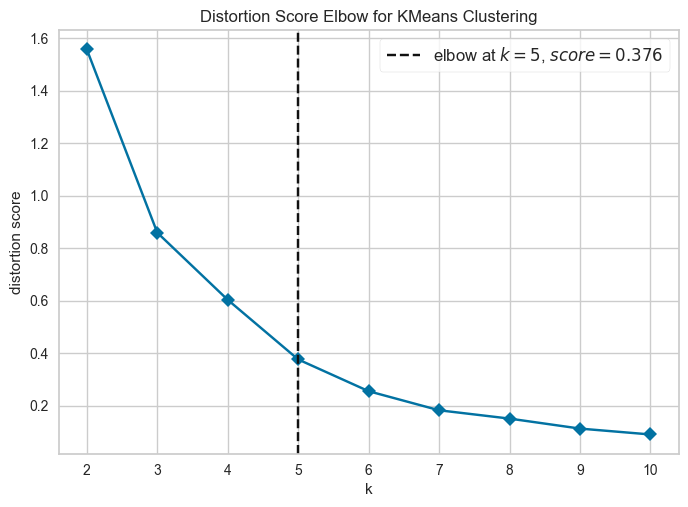

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [144]:
yellowbrick.style.rcmod.set_style(style="whitegrid")

elbow_vis = KElbowVisualizer(KMeans(n_init=10), k=10, timings=False)
elbow_vis.fit(df_returns.copy())
elbow_vis.show()

In [145]:
k = elbow_vis.elbow_value_
model = KMeans(n_clusters = k, random_state = 42, n_init=10)

In [146]:
df_clustered = df_returns.copy()
df_clustered['Cluster'] = model.fit_predict(df_returns.values)

In [147]:
df_clustered["Cluster"] = df_clustered["Cluster"].astype(str)
df_clustered = df_clustered.sort_values(by="Cluster")

fig = px.scatter(df_clustered,
                 x="Volatility", y="Returns", color="Cluster",
                 title="Return x Volatility")
fig.update_traces(marker_size=15)
fig.show()

In [148]:
returns_by_cluster = []
for cluster in df_clustered["Cluster"].unique():
    tickers = df_clustered[df_clustered["Cluster"] == cluster].index.to_list()
    print(f"{cluster = }, {tickers = }")    
    
    returns_by_cluster.append(df[tickers].pct_change().mean(axis=1).dropna())

cluster = '0', tickers = ['ETH-USD', 'BTC-USD']
cluster = '1', tickers = ['SBSP3.SA', 'PETR4.SA', 'EQTL3.SA', 'LEVE3.SA', 'CMIG4.SA', 'KLBN11.SA', 'SUZB3.SA', 'VALE3.SA', 'B3SA3.SA', 'CCRO3.SA']
cluster = '2', tickers = ['POMO4.SA', 'UGPA3.SA', 'MULT3.SA', 'LREN3.SA', 'ABEV3.SA', 'ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA']
cluster = '3', tickers = ['JBSS3.SA', 'WEGE3.SA', 'CSNA3.SA', 'KEPL3.SA']
cluster = '4', tickers = ['GBPUSD=X', 'EURUSD=X', 'EGIE3.SA', 'BRL=X', 'BOVA11.SA', '^GSPC']


In [149]:
benchmark = yf.download("^BVSP", start=start_date, end=end_date)["Adj Close"].pct_change()

[*********************100%%**********************]  1 of 1 completed


In [150]:
fig = px.line()

for i, returns in enumerate(returns_by_cluster):
    fig.add_scatter(x=returns.index, y=returns.cumsum()*100, mode='lines', name=f'Cluster {i}')

fig.add_scatter(x=benchmark.index, y=benchmark.cumsum()*100, mode='lines', name='IBOV')
    
fig.update_layout(title='Portfolio Simulation - All History',
                      xaxis_title='Date',
                      yaxis_title='Cumulative Returns',
                      legend_title='Tickers')

fig.show()

In [151]:
returns_by_cluster = []
for cluster in df_clustered["Cluster"].unique():
    tickers = df_clustered[df_clustered["Cluster"] == cluster].index.to_list()
    print(f"{cluster = }, {tickers = }")    
    
    returns_by_cluster.append(df_test[tickers].pct_change().mean(axis=1).dropna())

benchmark = benchmark[end_train_date:end_date]

cluster = '0', tickers = ['ETH-USD', 'BTC-USD']
cluster = '1', tickers = ['SBSP3.SA', 'PETR4.SA', 'EQTL3.SA', 'LEVE3.SA', 'CMIG4.SA', 'KLBN11.SA', 'SUZB3.SA', 'VALE3.SA', 'B3SA3.SA', 'CCRO3.SA']
cluster = '2', tickers = ['POMO4.SA', 'UGPA3.SA', 'MULT3.SA', 'LREN3.SA', 'ABEV3.SA', 'ITSA4.SA', 'ITUB4.SA', 'BBAS3.SA']
cluster = '3', tickers = ['JBSS3.SA', 'WEGE3.SA', 'CSNA3.SA', 'KEPL3.SA']
cluster = '4', tickers = ['GBPUSD=X', 'EURUSD=X', 'EGIE3.SA', 'BRL=X', 'BOVA11.SA', '^GSPC']


In [152]:
fig = px.line()

for i, returns in enumerate(returns_by_cluster):
    fig.add_scatter(x=returns.index, y=returns.cumsum()*100, mode='lines', name=f'Cluster {i}')

fig.add_scatter(x=benchmark.index, y=benchmark.cumsum()*100, mode='lines', name='IBOV')
    
fig.update_layout(title='Portfolio Simulation - Test History',
                      xaxis_title='Date',
                      yaxis_title='Cumulative Returns',
                      legend_title='Tickers')

fig.show()